In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check content of drive
!ls "/content/drive/My Drive/THESIS 2/Thesis Internal/Code"

 01_models_test_cases					  'old datasets used'
 audio_augmentation					   Pretagging
 Axl_Test						   resnet_testcases.gsheet
 binary_audio_cleaned_cropped				   Russel_Test
 binary_test_split_audio_Depression_AVEC2017_2		   test_binary_vandanaModel.ipynb
 binary_train_split_audio_Depression_AVEC2017_2		   test_customModel1.ipynb
'Copy of test_InceptionV3_model1 [ITO NA YUN AXL].ipynb'   test_inceptionV3_model1.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2		   test_InceptionV3_model1_V2.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2_VERSION2   test_predict
 Eli_Test						   test_split_audio_Depression_AVEC2017_2
'Final Models'						   test_split_mfcc_Depression_AVEC2017_2
 inceptionV3_model1_testcases.gsheet			   train_split_audio_Depression_AVEC2017_2
 model							   train_split_mfcc_Depression_AVEC2017_2
 model_tuning


In [4]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Change your print statement to reflect the 5 classes
total_image = np.concatenate([train_ds.labels, val_ds.labels])
class_counts = {}
for i in range(5):
    class_name = f'level_{i}'
    class_counts[class_name] = len(np.where(total_image==i)[0])

print('\n\n', class_counts)


Found 130 images belonging to 5 classes.
Found 12 images belonging to 5 classes.
Found 47 images belonging to 5 classes.
Found 567 images belonging to 5 classes.


 {'level_0': 64, 'level_1': 35, 'level_2': 25, 'level_3': 13, 'level_4': 5}


## Visualizing the dataset

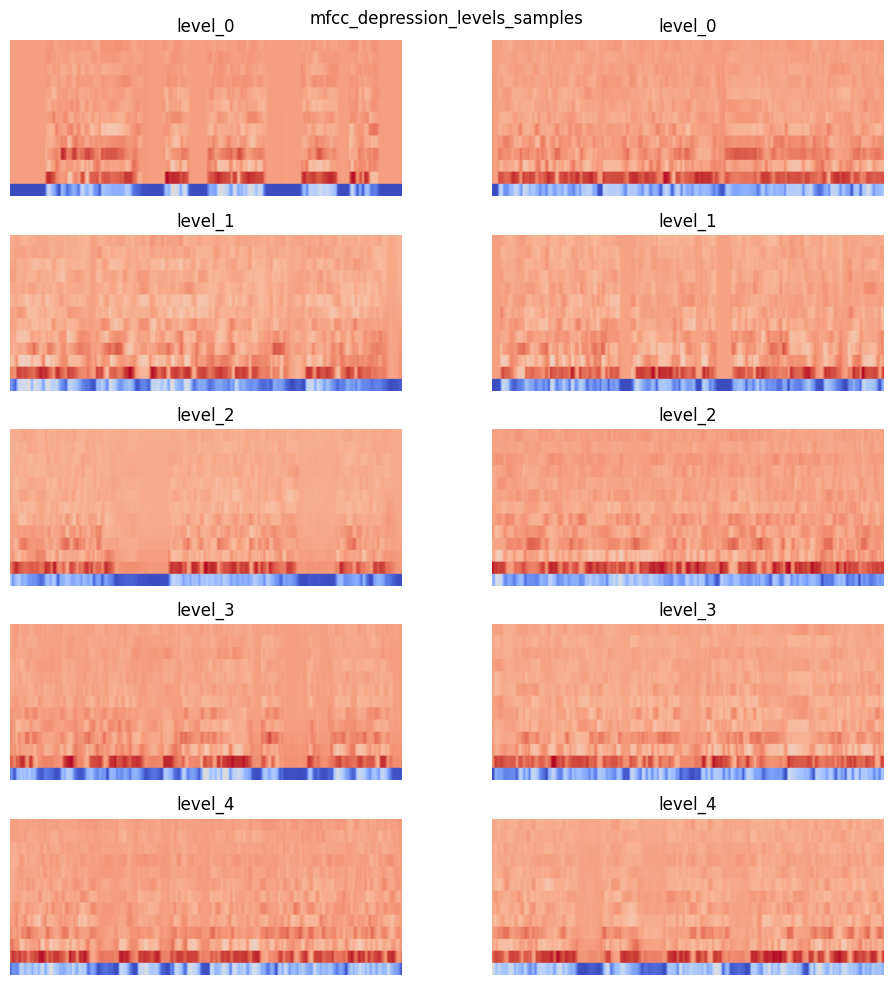

In [6]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


## Visualizing the augmented dataset

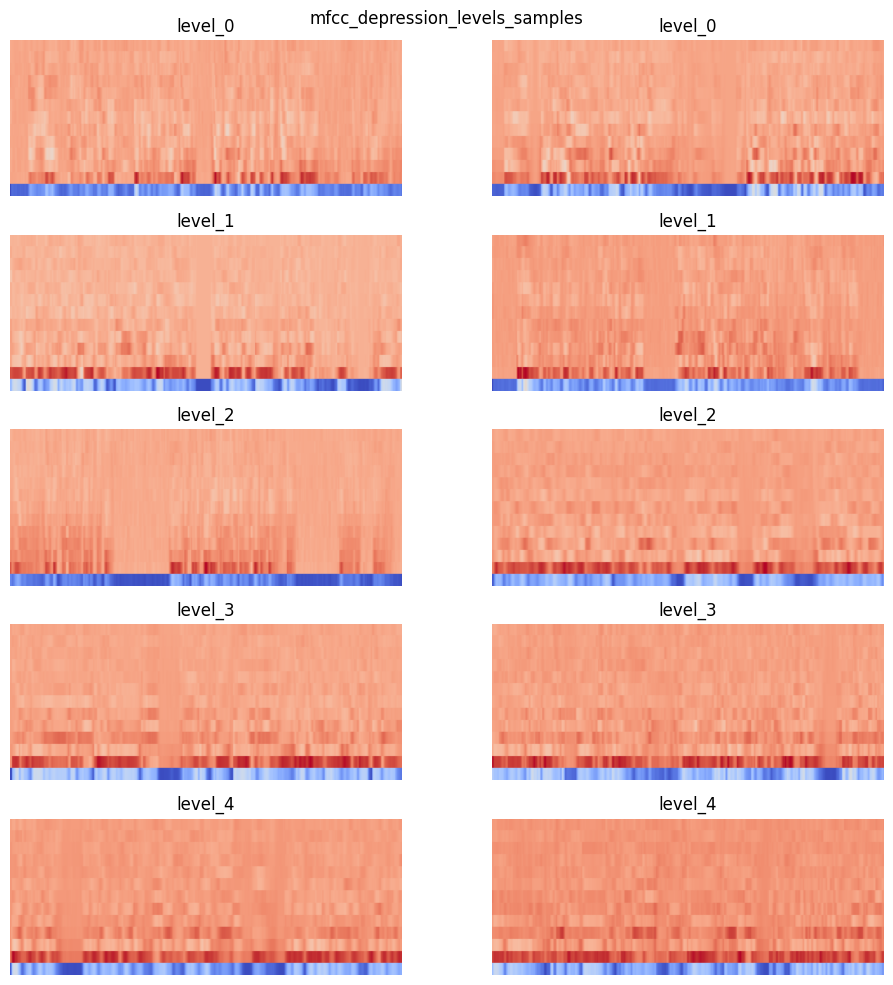

In [7]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = aug_train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


# Applying Class Weights to address Imbalanced dataset

In [8]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


## To keep track of Time duration during training

In [9]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial ResNet50 + BiLSTM Model


In [10]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Assuming height and width are defined elsewhere in your code
input_shape = (height, width, 3)

# Using ResNet50 as the base model
base_model_resnet50 = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Make the last block of the ResNet trainable
for layer in base_model_resnet50.layers[:-10]:
    layer.trainable = False

# Define the model
model = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Flatten the output of the base model to a vector
    tf.keras.layers.Flatten(),

    # Reshape to a sequence for the LSTM, treating each element as a timestep
    # Choose a sequence length that makes sense for your model; here we assume 1024
    tf.keras.layers.Reshape((1024, 1)),

    # Bi-LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),

    # Classifier head
    tf.keras.layers.Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),  # Adam optimizer
    metrics=['accuracy']  # Using 'accuracy' instead of 'acc' for clarity
)

model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 32, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                         

In [11]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial_hybrid.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]
# callbacks_list = [checkpoint]

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.1769
Epoch 1: val_loss improved from inf to 1.61067, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial_hybrid.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 45.16 seconds
5/5 [==============================] - 45s 6s/step - loss: 1.6085 - accuracy: 0.1769 - val_loss: 1.6107 - val_accuracy: 0.1667
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.5984 - accuracy: 0.1769
Epoch 2: val_loss did not improve from 1.61067
Epoch 2: 4.58 seconds
5/5 [==============================] - 5s 1s/step - loss: 1.5984 - accuracy: 0.1769 - val_loss: 1.6122 - val_accuracy: 0.1667
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.5838 - accuracy: 0.2154
Epoch 3: val_loss did not improve from 1.61067
Epoch 3: 4.62 seconds
5/5 [==============================] - 5s 814ms/step - loss: 1.5838 - accuracy: 0.2154 - val_loss: 1.6137 - val_accuracy: 0.1667
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.2000
Epoch 4: val_loss did not improve from 1.61067
Epoch 4: 4.65 seconds
5/5 [==============================] - 5s 818ms/step - loss: 1.5791 - accuracy: 0.2000 - val_loss: 1.6159 - val_

## Evaluation of *Initial Model*

In [12]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 9s 7s/step - loss: 1.6137 - accuracy: 0.1064


,Train,Val,Test
Loss,1.610499,1.610673,1.613725
Acc,0.176923,0.166667,0.106383


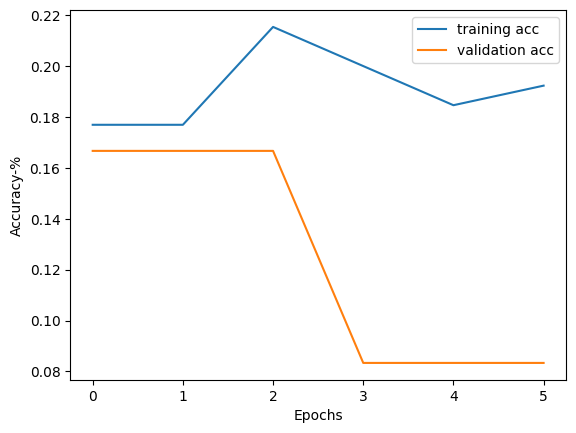

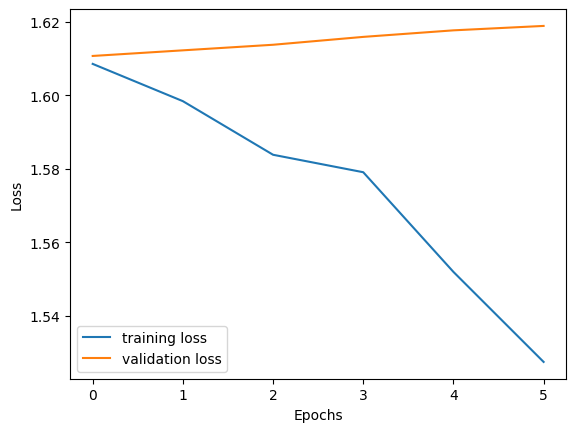

In [13]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 3s 393ms/step
Test Metrics DataFrame:
               Test
Precision  0.904934
Recall     0.106383
F1 Score   0.020458
AUC        0.475290

Test Confusion Matrix:
[[ 0  0 22  0  0]
 [ 0  0 11  0  0]
 [ 0  0  5  0  0]
 [ 0  0  7  0  0]
 [ 0  0  2  0  0]]


In [15]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (5.0, 0.0, 42.0, 0.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


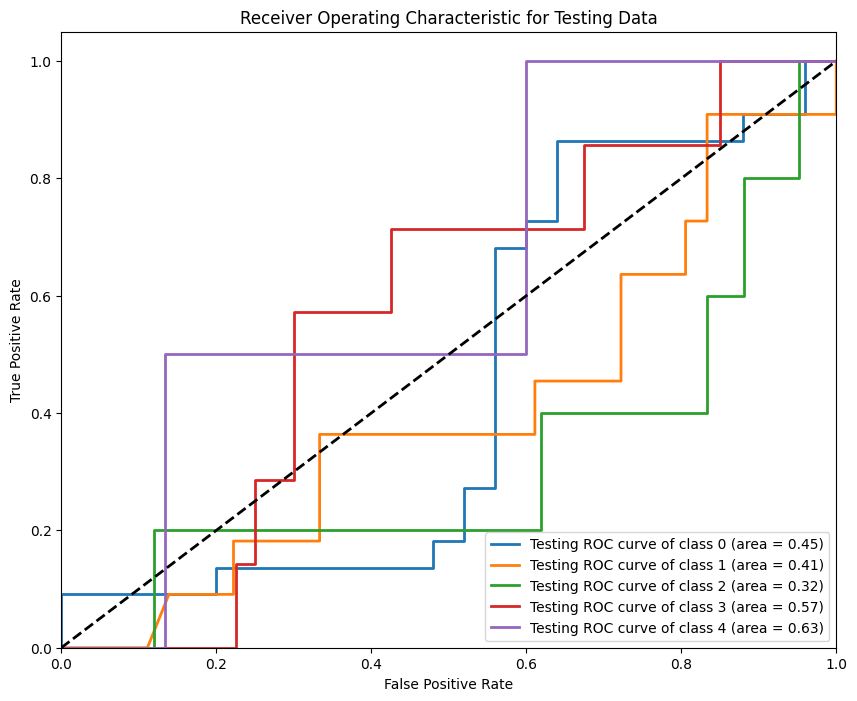

In [16]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

**TEST CASES INSERTION**

In [17]:
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('resnet50_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [18]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.1587
Epoch 1: val_loss did not improve from 1.61067
Epoch 1: 148.89 seconds
18/18 [==============================] - 149s 8s/step - loss: 1.6087 - accuracy: 0.1587 - val_loss: 1.6165 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.5943 - accuracy: 0.1693
Epoch 2: val_loss did not improve from 1.61067
Epoch 2: 17.86 seconds
18/18 [==============================] - 18s 967ms/step - loss: 1.5943 - accuracy: 0.1693 - val_loss: 1.6152 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.5732 - accuracy: 0.1834
Epoch 3: val_loss did not improve from 1.61067
Epoch 3: 18.56 seconds
18/18 [==============================] - 19s 1s/step - loss: 1.5732 - accuracy: 0.1834 - val_loss: 1.6222 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - los

## Evaluation of *Initial Model* with **Augmentation**

In [19]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 435ms/step - loss: 1.6156 - accuracy: 0.1489


,Train,Val,Test
Loss,1.615079,1.615189,1.615623
Acc,0.092308,0.083333,0.148936


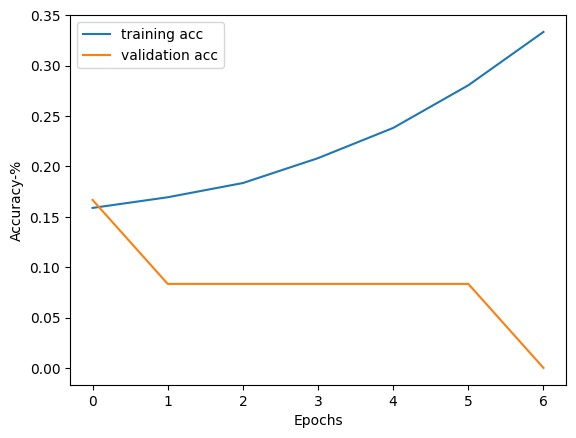

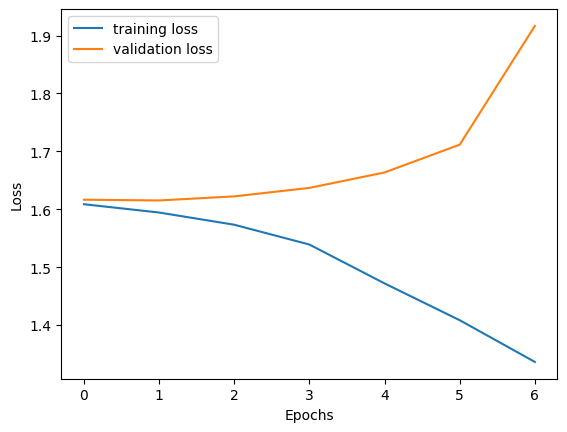

In [20]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [21]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 435ms/step
Test Metrics DataFrame:
               Test
Precision  0.873246
Recall     0.148936
F1 Score   0.038613
AUC        0.533753

Test Confusion Matrix:
[[ 0  0  0 22  0]
 [ 0  0  0 11  0]
 [ 0  0  0  5  0]
 [ 0  0  0  7  0]
 [ 0  0  0  2  0]]


In [22]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (7.0, 0.0, 40.0, 0.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


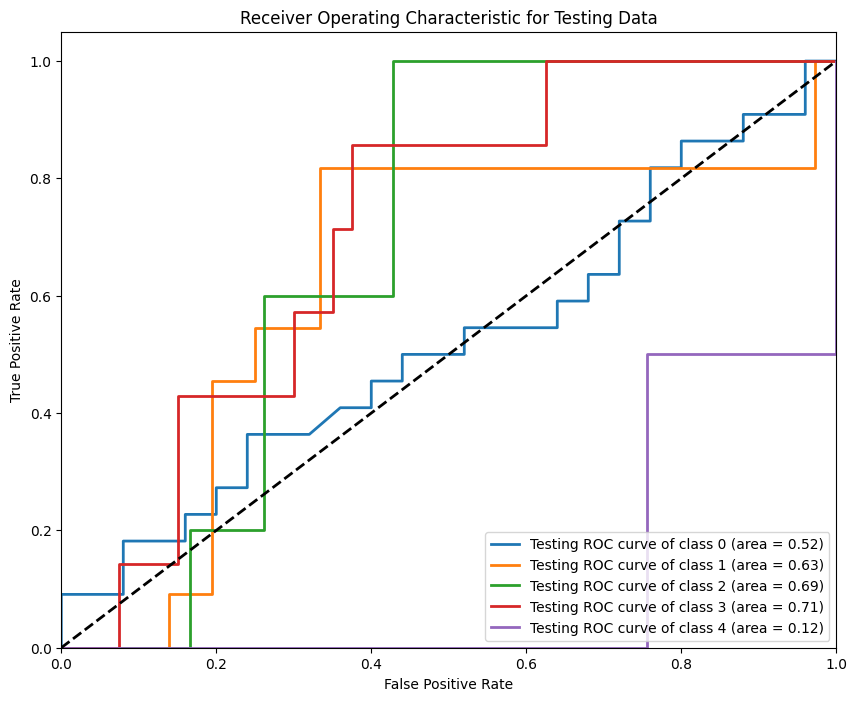

In [23]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [24]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Tuned VGG16 + BiLSTM Model

In [31]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Assuming height and width are defined elsewhere in your code
input_shape = (height, width, 3)

# Using ResNet50 as the base model
base_model_resnet50 = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Make the last block of the ResNet trainable
for layer in base_model_resnet50.layers[:-10]:
    layer.trainable = False

# Define the model
model = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Reduced dropout to prevent too much information loss

    # Additional Dense layer for more complex representations
    tf.keras.layers.Dense(512, activation='relu'),  # New Dense layer added
    tf.keras.layers.Dropout(0.3),  # Consistent dropout for regularization

    tf.keras.layers.Flatten(),

    # Reshape to a sequence for the LSTM, treating each element as a timestep
    # Choose a sequence length that makes sense for your model; here we assume 1024
    tf.keras.layers.Reshape((512, 1)),

    # Bi-LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),  # Return sequences for deeper model
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),  # Stacking another LSTM for better temporal learning

    # Classifier head
    tf.keras.layers.Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),  # Using learning rate schedule
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 32, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [32]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned_hybrid.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.6064 - accuracy: 0.1769
Epoch 1: val_loss improved from inf to 1.58369, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned_hybrid.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 21.10 seconds
5/5 [==============================] - 21s 2s/step - loss: 1.6064 - accuracy: 0.1769 - val_loss: 1.5837 - val_accuracy: 0.1667
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.5982 - accuracy: 0.1769
Epoch 2: val_loss improved from 1.58369 to 1.56136, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned_hybrid.h5
Epoch 2: 5.97 seconds
5/5 [==============================] - 6s 1s/step - loss: 1.5982 - accuracy: 0.1769 - val_loss: 1.5614 - val_accuracy: 0.1667
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.5811 - accuracy: 0.1769
Epoch 3: val_loss improved from 1.56136 to 1.53913, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned_hybrid.h5
Epoch 3: 5.99 seconds
5/5 [==============================] - 6s 1s/step - loss: 1.5811 - accuracy: 0.1769 - val_loss: 1.5391 - val_accuracy: 0.1667
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss

## Evaluation of *Tuned Model*

In [33]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 2s 431ms/step - loss: 1.4741 - accuracy: 0.2340


,Train,Val,Test
Loss,1.409769,1.347307,1.474146
Acc,0.246154,0.250000,0.234043


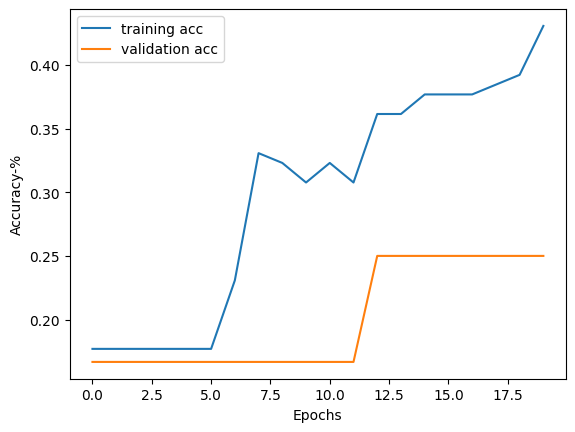

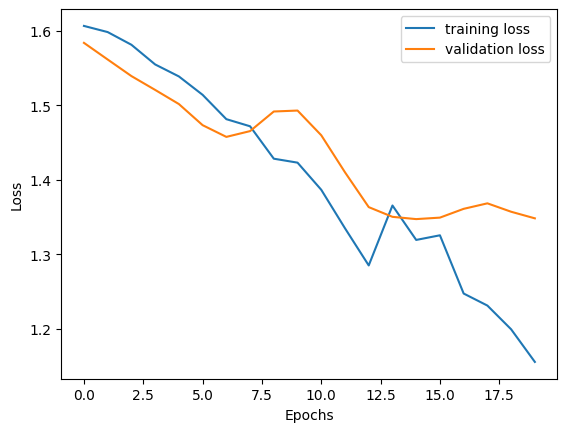

In [34]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [35]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 4s 414ms/step
Test Metrics DataFrame:
               Test
Precision  0.820733
Recall     0.234043
F1 Score   0.088775
AUC        0.538544

Test Confusion Matrix:
[[ 0 22  0  0  0]
 [ 0 11  0  0  0]
 [ 0  5  0  0  0]
 [ 0  7  0  0  0]
 [ 0  2  0  0  0]]


In [36]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (11.0, 0.0, 36.0, 0.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


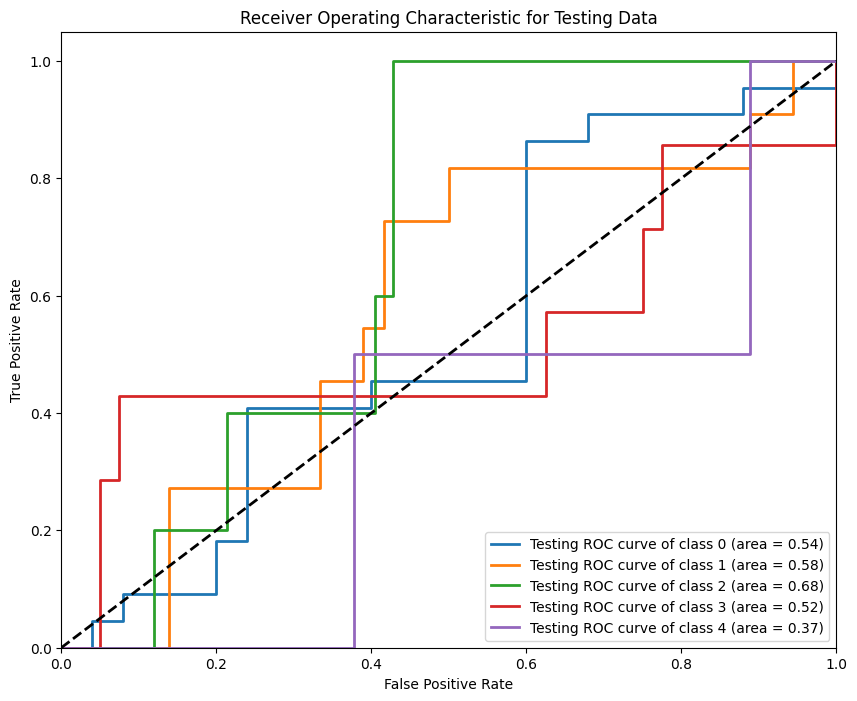

In [37]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [38]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [39]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.5822 - accuracy: 0.2840
Epoch 1: val_loss did not improve from 1.34731
Epoch 1: 18.41 seconds
18/18 [==============================] - 18s 1s/step - loss: 1.5822 - accuracy: 0.2840 - val_loss: 1.4352 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.4528 - accuracy: 0.3245
Epoch 2: val_loss did not improve from 1.34731
Epoch 2: 18.31 seconds
18/18 [==============================] - 18s 991ms/step - loss: 1.4528 - accuracy: 0.3245 - val_loss: 1.4960 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.3597 - accuracy: 0.3721
Epoch 3: val_loss did not improve from 1.34731
Epoch 3: 18.03 seconds
18/18 [==============================] - 18s 978ms/step - loss: 1.3597 - accuracy: 0.3721 - val_loss: 1.4981 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - lo

## Evaluation of *Tuned Model* with **Augmentation**

In [40]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 428ms/step - loss: 1.5014 - accuracy: 0.2340


,Train,Val,Test
Loss,1.462422,1.435229,1.501358
Acc,0.246154,0.250000,0.234043


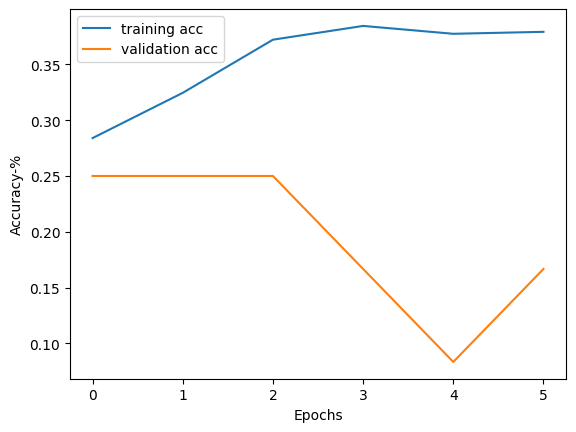

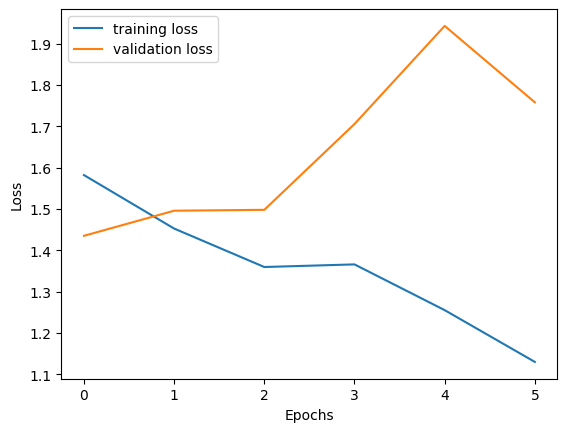

In [41]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [42]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 2s 424ms/step
Test Metrics DataFrame:
               Test
Precision  0.820733
Recall     0.234043
F1 Score   0.088775
AUC        0.547374

Test Confusion Matrix:
[[ 0 22  0  0  0]
 [ 0 11  0  0  0]
 [ 0  5  0  0  0]
 [ 0  7  0  0  0]
 [ 0  2  0  0  0]]


In [43]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (11.0, 0.0, 36.0, 0.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


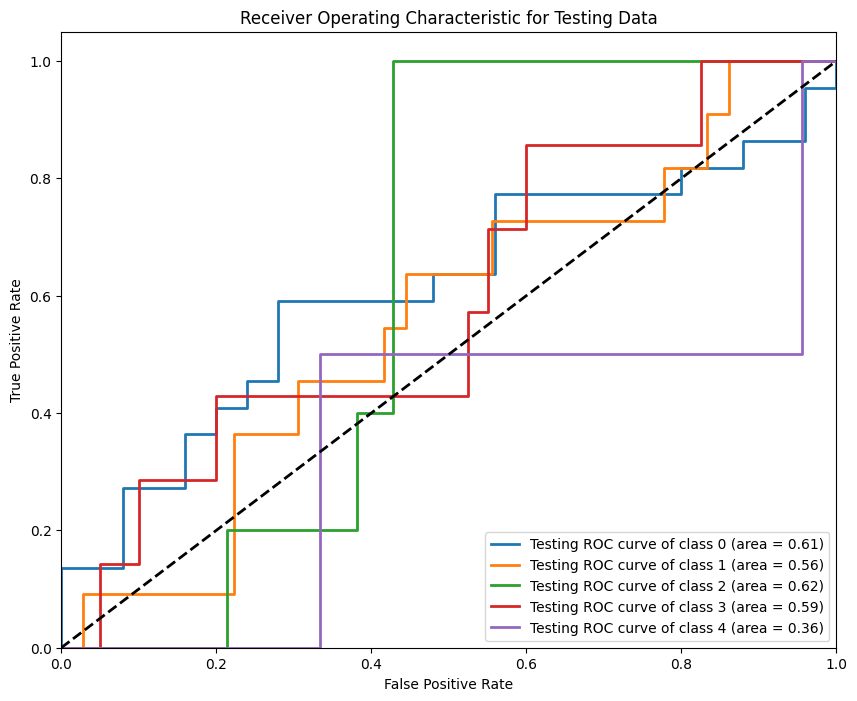

In [44]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [45]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Metrics of Final Model

In [46]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [47]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [48]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
